In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import glob
import os
import matplotlib.pyplot as plt
import math

#Umap
import matplotlib.pyplot as plt
from umap.umap_ import UMAP

from pointgrid import align_points_to_grid

# t-SNE
from sklearn.manifold import TSNE
from sklearn.manifold import trustworthiness

# faster tsne

# from cuml.manifold import TSNE as cumlTSNE


#Wordclouds
from wordcloud import WordCloud
from PIL import Image, ImageDraw

from os import path
import multidict as multidict

from scipy.spatial import ConvexHull
from scipy import interpolate

#hdbscan
import hdbscan

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [3]:
# Import
path_in = 'data/csv/freihand_signatures.csv'

df = pd.read_csv(path_in)
df = df.fillna('')

# Export 
columns_export =['id', 'lang', 'title', 'year', 'embedding_x', 'embedding_y', 'cluster', 'subject_list']

path_out = '../BHVizApp/src/data/mapping_out_sample.csv'

In [4]:
df.head()

,bvb,title,signature,inventory_nr,inventory_date,inventory_year,lang,year,sys,text,text_1,text_2,text_3,sig_lev_1,sig_lev_2
0,BV000001769,Sozialgeschichte der mittelalterlichen Kunst,Mk 1020-5571,2019.4415,20190926.0,2019.0,,1957.0,Mk 1020,interkontinental_und_Europa_allgemein._Mittela...,Kunst_allgemein_(ohne_Italien_speziell),Geschichte_der_Kunst_(allgemein_oder_vermischt...,Australien_und_Südsee_(Ozeanien),M,Mk
1,BV001953292,Sozialgeschichte der mittelalterlichen Kunst,Mk 1020-5571,2019.4415,20190926.0,2019.0,ger,1957.0,Mk 1020,interkontinental_und_Europa_allgemein._Mittela...,Kunst_allgemein_(ohne_Italien_speziell),Geschichte_der_Kunst_(allgemein_oder_vermischt...,Australien_und_Südsee_(Ozeanien),M,Mk
2,BV005486424,Homo caelestis,Mk 1020-5651/1,,0.0,,,1965.0,Mk 1020,interkontinental_und_Europa_allgemein._Mittela...,Kunst_allgemein_(ohne_Italien_speziell),Geschichte_der_Kunst_(allgemein_oder_vermischt...,Australien_und_Südsee_(Ozeanien),M,Mk
3,BV005486424,Homo caelestis,Mk 1020-5651/1,,0.0,,,1965.0,Mk 1020,interkontinental_und_Europa_allgemein._Mittela...,Kunst_allgemein_(ohne_Italien_speziell),Geschichte_der_Kunst_(allgemein_oder_vermischt...,Australien_und_Südsee_(Ozeanien),M,Mk
4,BV038967812,Homo caelestis,Mk 1020-5651/1,,0.0,,ger,1965.0,Mk 1020,interkontinental_und_Europa_allgemein._Mittela...,Kunst_allgemein_(ohne_Italien_speziell),Geschichte_der_Kunst_(allgemein_oder_vermischt...,Australien_und_Südsee_(Ozeanien),M,Mk


In [5]:
# 10'000 sample points for fast plotting
df = df.sample(10000)

## Word Tokenization

In [6]:
# text cols for wordclouds, cluster cols for clustering
text_cols = ['text', 'text_3', 'text_2', 'text_1']
cluster_cols = ['sig_lev_1', 'sig_lev_2', 'sys']

# one-hot encoding on the cluster_cols
df_cluster = pd.get_dummies(df[cluster_cols])

df['subject_list'] = df[text_cols].apply(lambda x: ' '.join(x.astype(str)), axis=1)

# #Bag of words approach
# vectorizer = CountVectorizer(min_df=5)
# subject_doc_matrix = vectorizer.fit_transform(df.subject_list)

#Tfidf approach
# tfidf = TfidfVectorizer()
# subject_doc_matrix = tfidf.fit_transform(df.cluster_list)

# Dimensionality Reduction

## Embedding

In [9]:
## Tsne
# perplexity = 500
# learning_rate = 200
# n_iter = 1000
# metric = 'euclidean'

# tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, metric=metric, init='random')
# x_tsne = tsne.fit_transform(subject_doc_matrix)

# emb = x_tsne

# UMAP

n_neighbors = 100
metric = 'hamming'
min_dist = 0.0

umap = UMAP(n_components=2, n_neighbors=n_neighbors, metric=metric, min_dist=min_dist, 
                                 spread=1.0, random_state=42, verbose=False)
x_umap = umap.fit_transform(df_cluster)

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


In [10]:
emb = x_umap

### Scale embedding

In [11]:
# Normalize 

embedding = emb * 100 # Multiply by 100
embedding = align_points_to_grid(embedding)

# Swap axes for horizontal position

ptp = np.ptp(embedding, axis=0)
if ptp[1]> ptp[0]:
    embedding[:, [1, 0]] = embedding[:, [0, 1]]

# Set range of values normalized to dimension with higher extent

extent = (embedding[:,0].min(), embedding[:,0].max()) if (embedding[:,0].max() - embedding[:,0].min()) > (embedding[:,1].max() - embedding[:,1].min()) else (embedding[:,1].min(), embedding[:,1].max())
resolution = (-1000, 1000)

embedding[:, 0] = np.interp(embedding[:,0], extent, resolution)
embedding[:, 1] = np.interp(embedding[:,1], extent, resolution)

# # Set origin at the middle

# ptp = np.ptp(embedding, axis=0)  
# embedding[:, 0] = embedding[:, 0] - ptp[0] / 2
# embedding[:, 1] = embedding[:, 1] - ptp[1] / 2

embedding = embedding.astype(int) # Set integer

embedding

array([[-335,  458],
       [ 424,  566],
       [-436, -342],
       ...,
       [ 905,  382],
       [ 259,  599],
       [ 512,  523]])

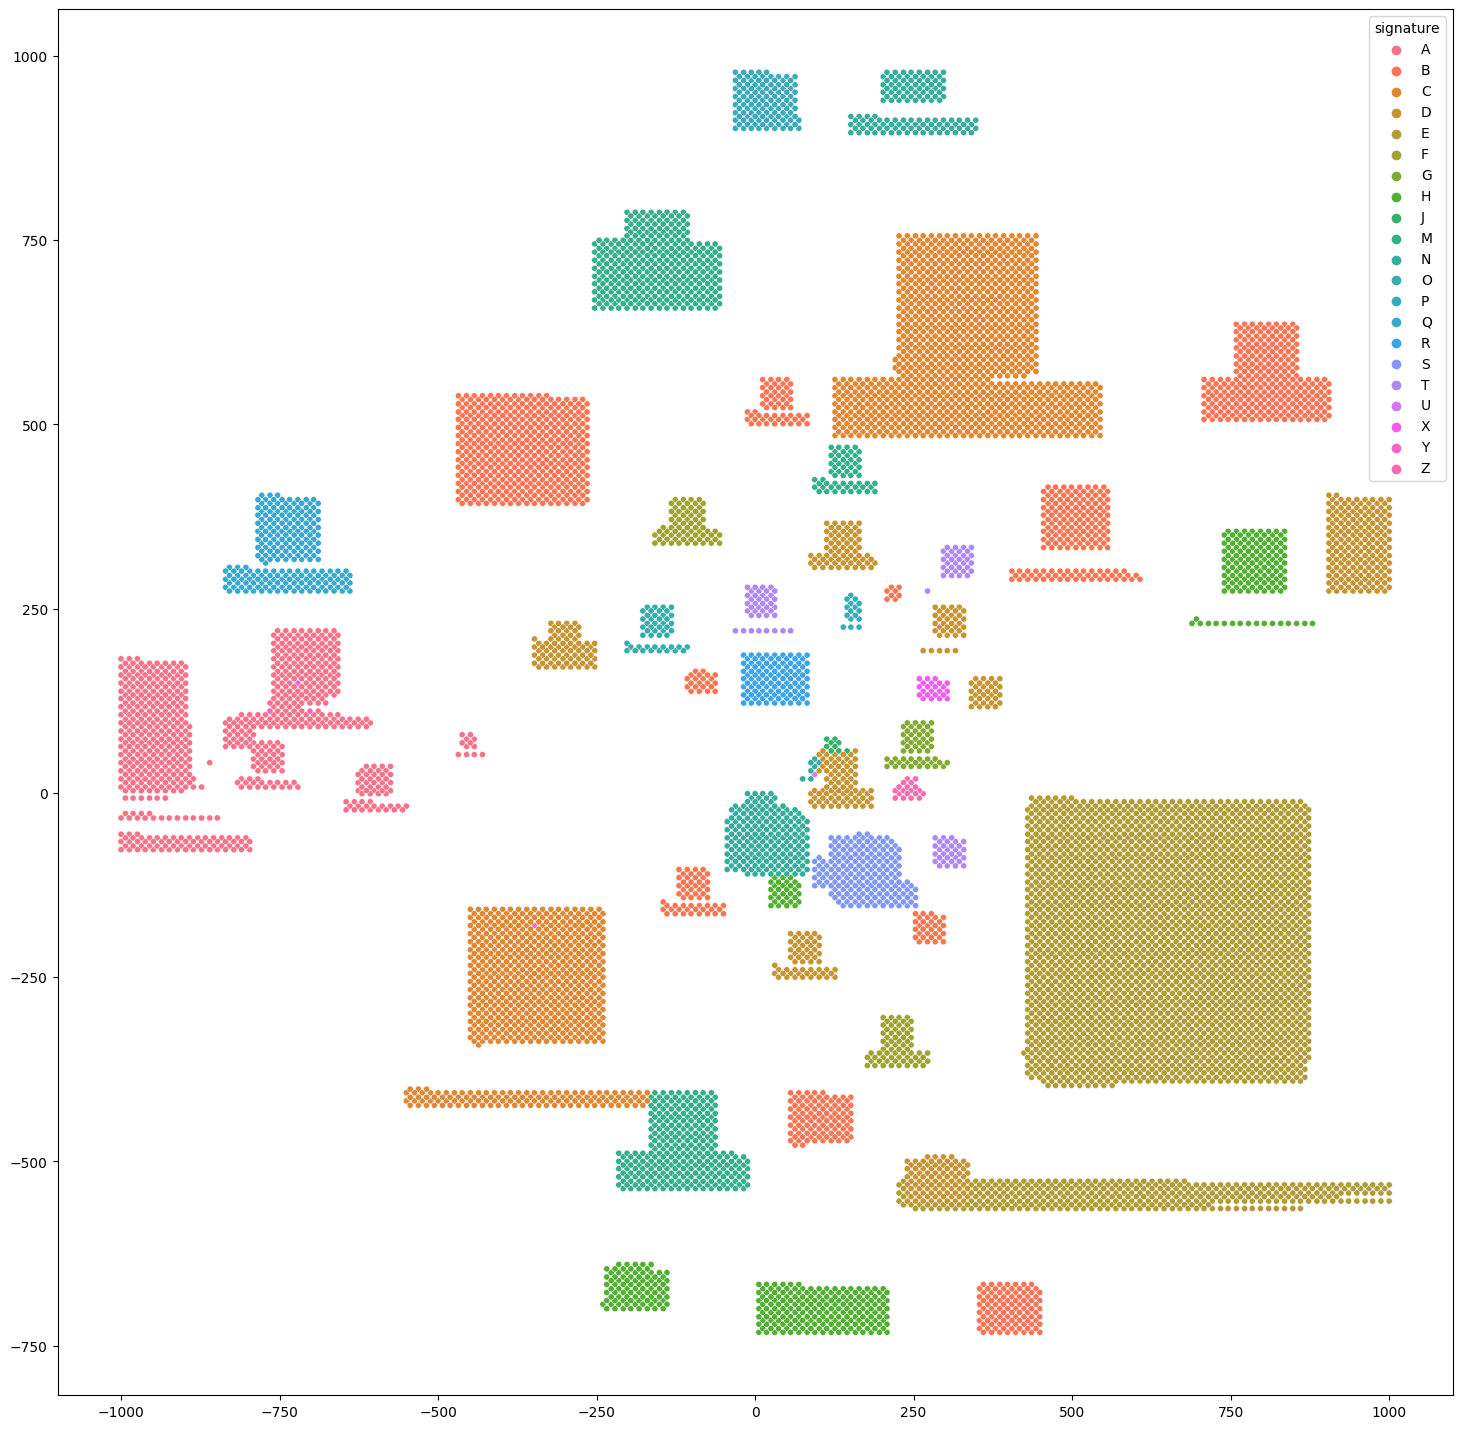

In [12]:
#Plot the embedding
fig, ax = plt.subplots(figsize=(18, 18))

# Get the unique values in the column and sort them alphabetically
order = sorted(df.signature.astype(str).str[0].unique())

sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=df.signature.astype(str).str[0], hue_order=order, ax=ax, s=20)
plt.show()

# Cluster Identification

In [13]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=50, cluster_selection_method ='leaf')

clusterer.fit(embedding)
clusters = clusterer.labels_

# add cluster to dataframe

df['cluster'] = clusters

#Grouping by cluster

values = set(clusters)
if -1 in values: values.remove(-1)

clusters = [[index for index, cluster in enumerate(clusters) if cluster==value] for value in values]

In [14]:
len(clusters)

41

# Wordclouds

In [19]:
for index, cluster in enumerate(clusters):

    # Preprocessing

    scale = 4
    
    min_X = min([i[0] for i in embedding[cluster]]) * scale
    max_X = max([i[0] for i in embedding[cluster]]) * scale
    min_Y = min([i[1] for i in embedding[cluster]]) * scale
    max_Y = max([i[1] for i in embedding[cluster]]) * scale

    width = max_X - min_X; height = max_Y - min_Y
    
    #points = list(map(lambda i: (i[0] * scale - min_X, i[1] * scale - min_Y), embedding[cluster]))
    points = [(i[0] * scale - min_X, i[1] * scale - min_Y) for i in embedding[cluster]]

    # Hull

    hull = ConvexHull(points)

    x_hull = np.append(hull.points[hull.vertices,0], hull.points[hull.vertices,0][0])
    y_hull = np.append(hull.points[hull.vertices,1], hull.points[hull.vertices,1][0])
    
    # Interpolation
    
    dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
    dist_along = np.concatenate(([0], dist.cumsum()))
    spline, u = interpolate.splprep([x_hull, y_hull], u=dist_along, s=0)
    interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
    interp_x, interp_y = interpolate.splev(interp_d, spline)    
    interp_points = list(zip(interp_x, interp_y))

    # Create mask

    print(width, height)
    img = Image.new(mode = "RGBA", size = (width, height), color = (255, 255, 255))
    draw = ImageDraw.Draw(img)
    # draw.polygon(points, fill=(0,0,0))
    draw.polygon(interp_points, fill=(0,0,0))
    mask = np.array(img)


    # Collect text

    text = []
    for id in cluster:
        #text.append(df.iloc[id]['text_1'])
        text.append(df.iloc[id]['text_2'])
    text = ' '.join(text)
    dictionary = multidict.MultiDict()
    _dictionary = {}


    # Frequency

    for _word in text.split(" "):
        val = _dictionary.get(_word, 0)
        # _dictionary[_word.replace('_', ' ')] = val + 1
        _dictionary[_word] = val + 1
    for key in _dictionary:
        dictionary.add(key.replace('_', ' '), _dictionary[key])


    # Wordcloud

    max_words = math.ceil(len(dictionary)*.5)

    def split_on_underscore(text):
        return text.replace('_', ' ')


    wc = WordCloud(
        mode = "RGBA",
        color_func=lambda *args, **kwargs: (0, 0, 0),
        font_path = 'Lato-Regular.ttf',
        mask=mask,
        
        normalize_plurals=False,
        prefer_horizontal= 1,
        
        margin=40,

        background_color=None,
        # background_color='black',

        #max_words=max_words,
        
        min_font_size= 10,
        max_font_size= 50,
        # collocation_threshold = 20,
        relative_scaling = 0,
    )

    print(index, max_words, '-', end=' ')
    
    wc.generate_from_frequencies(dictionary) # generate word cloud

    file_path = path.join('data/' + f"{index:02}.png")
    
    wc.to_file('../BHVizApp/src/wordclouds/'+f"{index:02}.png") # store to file

788 516
0 1 - 812 584
1 1 - 788 520
2 1 - 380 520
3 1 - 380 500
4 1 - 400 304
5 1 - 736 328
6 1 - 808 260
7 1 - 380 260
8 1 - 2940 280
9 73 - 404 240
10 1 - 860 520
11 1 - 532 432
12 1 - 304 260
13 1 - 408 584
14 1 - 456 1016
15 4 - 656 760
16 4 - 560 520
17 1 - 404 500
18 1 - 352 240
19 1 - 608 236
20 1 - 400 392
21 5 - 276 304
22 1 - 428 456
23 1 - 480 280
24 6 - 452 432
25 5 - 376 584
26 19 - 380 456
27 19 - 480 280
28 23 - 756 648
29 46 - 808 628
30 51 - 428 672
31 27 - 352 452
32 22 - 276 496
33 16 - 428 344
34 23 - 1036 304
35 1 - 632 844
36 45 - 884 368
37 35 - 556 304
38 1 - 480 496
39 1 - 252 540
40 1 - 

# Export

In [18]:
# add coordinates to dataframe

df['embedding_x']  = embedding[:,0]
df['embedding_y']  = embedding[:,1]

df['id'] = df.bvb

df[columns_export].to_csv(path_out, index=False)